In [3]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
sys.path.append('../../TopographicVAE-master')
import torch
from torch import nn
import torch.nn.functional as F
import os
from itertools import islice
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging
from tqdm import tqdm

from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM, LVAE_IAF_Config, LVAE_IAF, GPVAE, GPVAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, Encoder_ColorMNIST,Decoder_ColorMNIST
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(grid, color=False):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def plot_sequence(X, patches=None):
    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(num_obs, num_seq))
    
    for i in range(num_seq):
        for j in range(num_obs):
            ax = plt.subplot(num_seq, num_obs, i * num_obs + j + 1)
            ax.imshow(X[i, j].transpose(1, 2, 0), cmap = 'gray')
            ax.axis('off')
            
            # Add red contour if patches is not None and j is in patches
            if patches is not None and j in patches[i]:
                rect = Rectangle((0.1, 0.1), X[i, j].shape[2]+0.2, X[i, j].shape[1]+0.2, 
                                 linewidth=6, edgecolor='c', facecolor='none')
                ax.add_patch(rect)
    
    plt.show()
    logger.setLevel(old_level)

def extract_train_embeddings(model, train_data, batch_size = 256):
    train_embeddings = [] 
    #log_vars = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False)
    for i, x in enumerate(train_loader):
        x = x.to('cuda')
        out = model.encoder(x)
        z = out.embedding.reshape(-1, model.n_obs, model.latent_dim)
        log_var = out.log_covariance
        train_embeddings.append(z.cpu().detach())
        #log_vars.append(log_var.cpu().detach())
    train_embeddings = torch.cat(train_embeddings, dim = 0)

    return train_embeddings


def plot_z_seqs(z_seq, train_embeddings):

    num_obs =  NUM_OBS =  train_embeddings.shape[1] 
    pca = PCA(n_components=2)
    n_samples = z_seq.shape[0]
    train_embeddings_pca = pca.fit_transform(train_embeddings.reshape(-1, latent_dim).cpu().detach().numpy()).reshape(-1, num_obs, 2)

    displayed_indexes = range(num_obs)  #range(num_obs)

    all_sequences = z_seq
    all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
    all_sequences_pca = all_sequences_pca.reshape(n_samples, -1, 2)
    plt.figure(figsize=(NUM_OBS, n_samples))
    plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
    colors = plt.get_cmap('tab10', num_obs)
    for i in displayed_indexes:
        plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Train obs. {i}')

    for i in range(n_samples):
        plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


    plt.legend()
    plt.show()



%reload_ext autoreload
%autoreload 2

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


torch.Size([700, 10, 1, 64, 64])


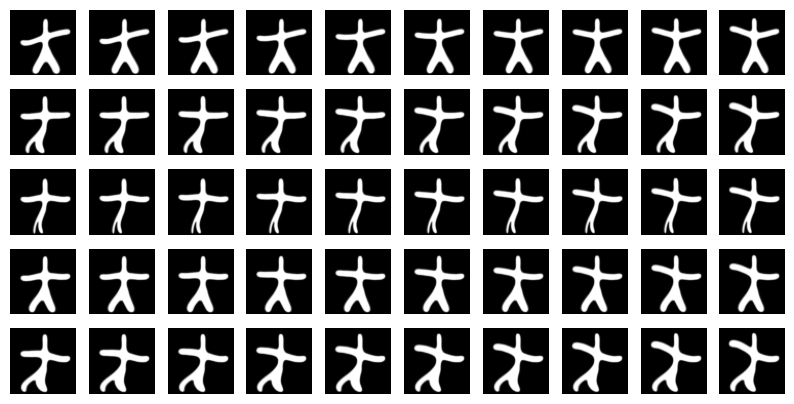

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load('starmen_data.pt')[:700].unsqueeze(2)
eval_data = torch.load('starmen_data.pt')[700:900].unsqueeze(2)
test_data = torch.load('starmen_data.pt')[900:].unsqueeze(2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

plot_sequence(train_data[:5])

In [3]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)


PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-08-01_16-38-44/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_2/checkpoints/epoch=99-step=1100.ckpt'


# Avec prior 'allongée' mais pas décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-27_11-46-10/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_7/checkpoints/epoch=49-step=1600.ckpt'


# Prior décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_15/checkpoints/epoch=49-step=1600.ckpt'

device = 'cpu'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  2.5014681816101074
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [4]:
model_config = LVAE_IAF_Config(
    input_dim=(1, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    #########################
    warmup=0,
    #########################
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=200,
        learning_rate=5*1e-4,
        batch_size=32,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=None, verbose = True, temp = temperature)
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-08-01_19-43-09/final_model/model.pt')['model_state_dict'])
lvae = LVAE_IAF.load_from_folder('lldm/LVAE_IAF_training_2024-08-26_11-24-27/final_model').to(device)
gpvae = GPVAE.load_from_folder('lldm/GPVAE_training_2024-09-26_19-07-04/final_model').to(device)



lldm.eval()
lvae.eval()
gpvae.eval()

Diffusion time steps  [999 889 778 667 556 445 334 223 112   1]
Running on  cpu
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


GPVAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )


## Testing reconstruction

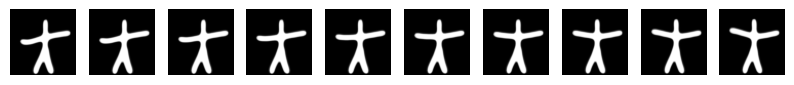

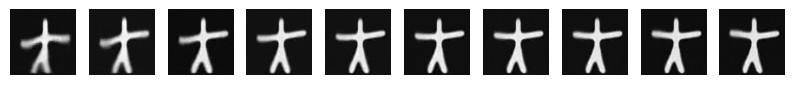

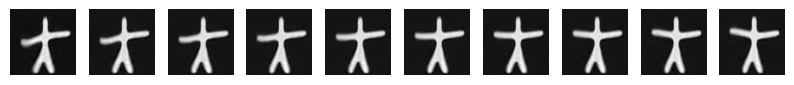

Reconstruction loss LLDM : 20.21868324279785
Reconstruction loss LVAE : 9.573440551757812


In [5]:
### TESTING RECONSTRUCTION ###
device = 'cpu'
lldm = lldm.to(device)
lldm.device = device
lldm = lldm.eval()
lvae  = lvae.to(device)
lvae.device = device
lvae = lvae.eval()

vi_index = 5

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 5)
_, x_rec_lvae = lvae.reconstruct(x, vi_index = 5)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))
plot_sequence(x_rec_lvae.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss LLDM :', recon_loss)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec_lvae.reshape(x.shape[0]*lldm.n_obs, -1).to(device),
                        x.reshape(x.shape[0]*lldm.n_obs, -1).to(device),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss LVAE :', recon_loss)


## Testing generation

### Unconditional

In [12]:
train_embeddings = extract_train_embeddings(lldm, train_data)
train_embeddings_lvae = extract_train_embeddings(lvae, train_data)

print(train_embeddings.shape)

torch.Size([700, 10, 12])


Running Kmedoids
Finding temperature
Best temperature found:  71.09940338134766
Building metric
Increasing T by  1
Sampling 5 points on the 4th/rd manifold...
Batch 1/1
Propagating in the past...
Propagating in the future...
Decoding...


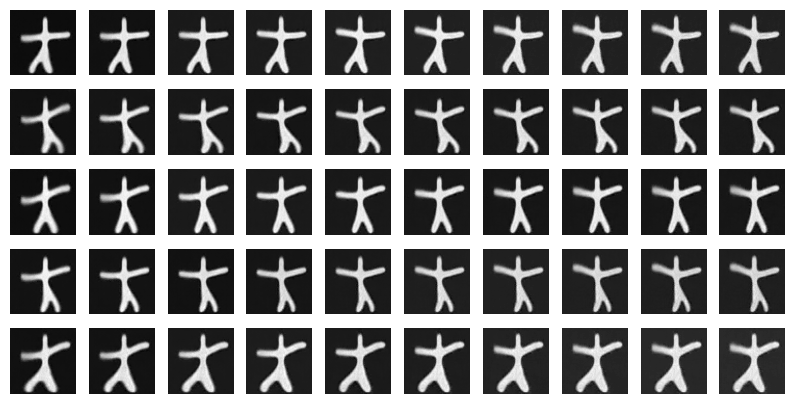

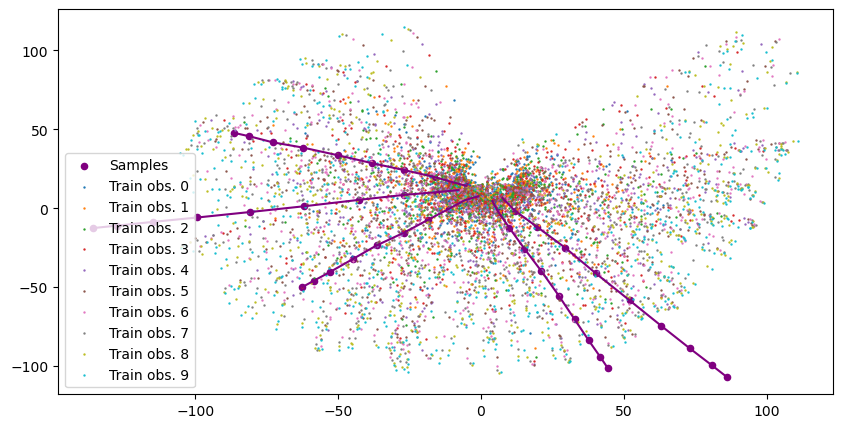

In [13]:
lldm.temperature = 1
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=5, vi_index = 4, T_multiplier = 1)
plot_sequence(recon_x)
plot_z_seqs(z_seq, train_embeddings)

## Conditional

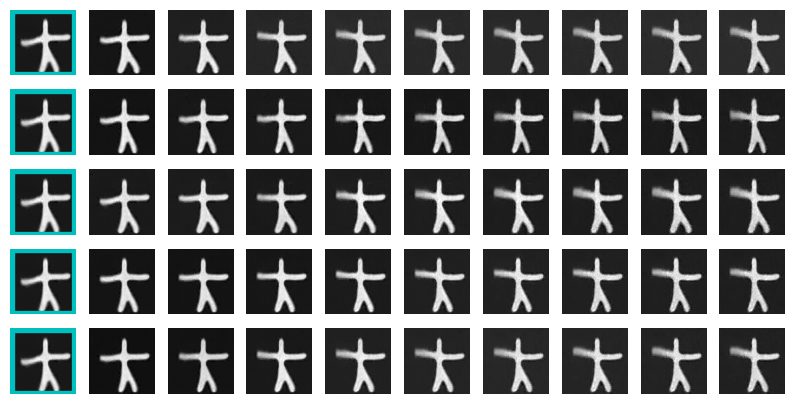

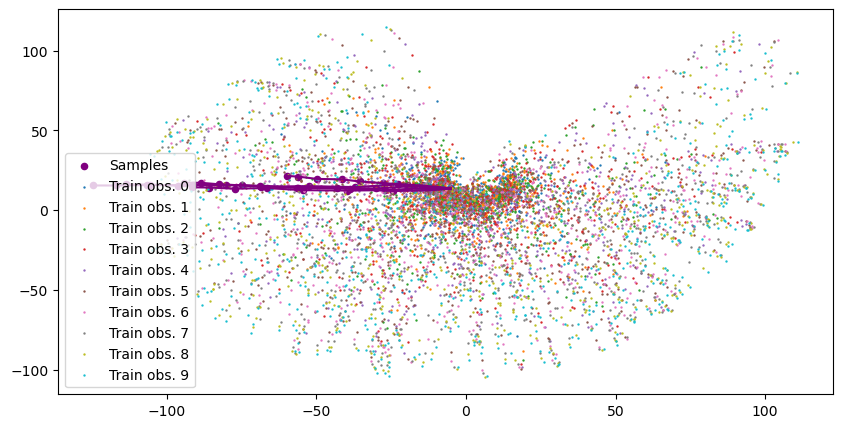

In [82]:
lldm.temperature = 2
num_gen_seq = 5
index = 0

recon_x, z_seq = lldm.generate(train_data, num_gen_seq=num_gen_seq, vi_index =index, T_multiplier = 0.1, freeze=True, verbose = False)
patches= [[index]]*num_gen_seq
plot_sequence(recon_x, patches)
plot_z_seqs(z_seq, train_embeddings)

## FID and IS

In [6]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =3 , T_multiplier = 1, verbose = False, batch_size = 128)
recon_x_lvae, z_seq_lvae = lvae.generate(random_normal=True,  num_gen_seq=test_data.shape[0])
print(recon_x.shape)
print(recon_x_lvae.shape)
print(test_data.shape)

Remainder batch size...: size 100
torch.Size([100, 10, 1, 64, 64])
torch.Size([100, 10, 1, 64, 64])
torch.Size([100, 10, 1, 64, 64])


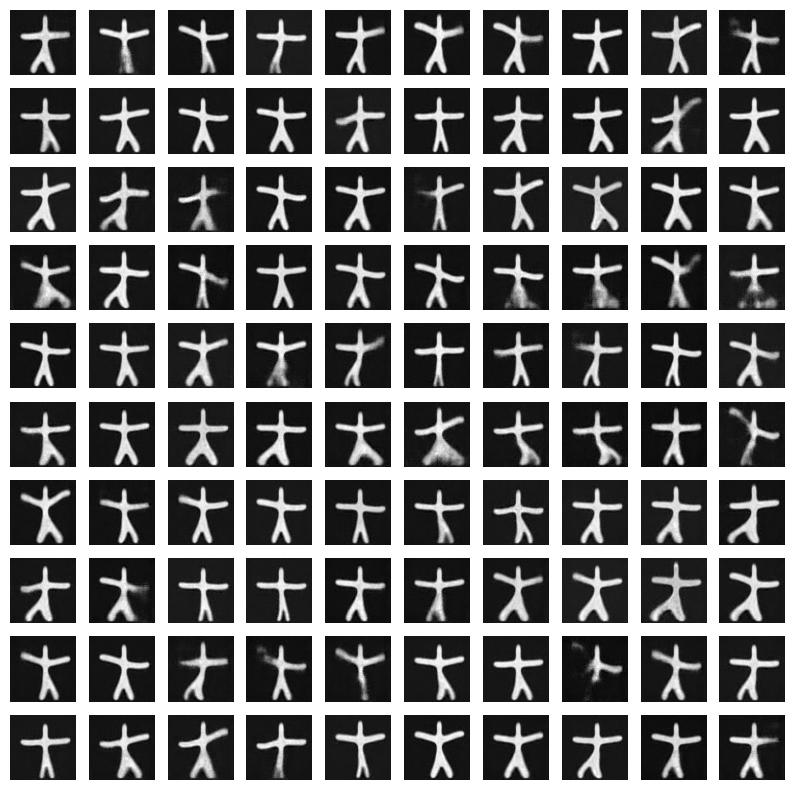

In [7]:
gpvae.time_length = test_data.shape[1]
recon_x_gpvae = gpvae.generate(test_data.shape[0], device = 'cpu')
plot_sequence(recon_x_gpvae[:10])

In [13]:
from torcheval.metrics import FrechetInceptionDistance
from tqdm import tqdm

def compute_fid_with_torcheval(real_images, generated_images, batch_size=256, device='cuda'):
    # Initialize FID metric
    fid_metric = FrechetInceptionDistance().to(device)
    
    def process_in_batches(images, real):
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            fid_metric.update(batch, is_real=real)
            # Clear the batch from memory
            del batch
            torch.cuda.empty_cache()
    
    # Process real images in batches
    process_in_batches(real_images, real=True)
    
    # Process generated images in batches
    process_in_batches(generated_images, real=False)
    
    # Compute the FID score
    fid_score = fid_metric.compute()
    return fid_score

# Example usage:
real_images = test_data.reshape(-1, 1, 64, 64).clamp(0, 1).repeat(1, 3, 1, 1)

In [18]:


all_scores_lldm = []
all_scores_lvae = []
for i in tqdm(range(5)):
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =7 , T_multiplier = 1, verbose = False, batch_size = 128)
    recon_x_lvae, z_seq_lvae = lvae.generate(random_normal=True,  num_gen_seq=test_data.shape[0])
    generated_images = recon_x.reshape(-1, 1, 64, 64).clamp(0, 1).repeat(1, 3, 1, 1).cuda()
    generated_images_lvae = recon_x_lvae.reshape(-1, 1, 64, 64).clamp(0, 1).repeat(1, 3, 1, 1).cuda()
    fid_score = compute_fid_with_torcheval(real_images, generated_images)
    print('FID score LLDM:', fid_score)
    fid_score_lvae = compute_fid_with_torcheval(real_images, generated_images_lvae)
    print('FID score LVAE:', fid_score_lvae)

    all_scores_lldm.append(fid_score.cpu().detach())
    all_scores_lvae.append(fid_score_lvae.cpu().detach())

print('-------------------')
print('Mean FID score LLDM:', np.mean(all_scores_lldm))
print('Mean FID score LVAE:', np.mean(all_scores_lvae))
print('Std FID score LLDM:', np.std(all_scores_lldm))
print('Std FID score LVAE:', np.std(all_scores_lvae))


  0%|          | 0/5 [00:00<?, ?it/s]

Remainder batch size...: size 100
FID score LLDM: tensor(35.2344, device='cuda:0')


 20%|██        | 1/5 [00:22<01:28, 22.19s/it]

FID score LVAE: tensor(42.6420, device='cuda:0')
Remainder batch size...: size 100
FID score LLDM: tensor(33.7383, device='cuda:0')


 40%|████      | 2/5 [00:47<01:11, 23.73s/it]

FID score LVAE: tensor(42.9106, device='cuda:0')
Remainder batch size...: size 100
FID score LLDM: tensor(31.1751, device='cuda:0')


 60%|██████    | 3/5 [01:11<00:48, 24.15s/it]

FID score LVAE: tensor(43.0622, device='cuda:0')
Remainder batch size...: size 100
FID score LLDM: tensor(35.7349, device='cuda:0')


 80%|████████  | 4/5 [01:34<00:23, 23.82s/it]

FID score LVAE: tensor(42.7265, device='cuda:0')
Remainder batch size...: size 100
FID score LLDM: tensor(35.8773, device='cuda:0')


100%|██████████| 5/5 [01:59<00:00, 23.93s/it]

FID score LVAE: tensor(40.9549, device='cuda:0')
-------------------
Mean FID score LLDM: 34.35201
Mean FID score LVAE: 42.45922
Std FID score LLDM: 1.7599484
Std FID score LVAE: 0.76617783


In [15]:
all_scores_gpvae = []
for i in tqdm(range(5)):
    recon_x_gpvae = gpvae.generate(test_data.shape[0], device = 'cpu')
    generated_images = recon_x.reshape(-1, 1, 64, 64).clamp(0, 1).repeat(1, 3, 1, 1).cuda()
    fid_score = compute_fid_with_torcheval(real_images, generated_images, device = 'cuda', batch_size=128)
    print('FID score GPVAE:', fid_score)
    all_scores_gpvae.append(fid_score.cpu().detach())

print('-------------------')
print('Mean FID score GPVAE:', np.mean(all_scores_gpvae))
print('Std FID score GPVAE:', np.std(all_scores_gpvae))

 20%|██        | 1/5 [00:06<00:25,  6.32s/it]

FID score GPVAE: tensor(37.5136, device='cuda:0')


 40%|████      | 2/5 [00:12<00:18,  6.29s/it]

FID score GPVAE: tensor(37.5136, device='cuda:0')


 60%|██████    | 3/5 [00:18<00:12,  6.27s/it]

FID score GPVAE: tensor(37.5136, device='cuda:0')


 80%|████████  | 4/5 [00:25<00:06,  6.27s/it]

FID score GPVAE: tensor(37.5136, device='cuda:0')


100%|██████████| 5/5 [00:31<00:00,  6.27s/it]

FID score GPVAE: tensor(37.5136, device='cuda:0')
-------------------
Mean FID score GPVAE: 37.513603
Std FID score GPVAE: 0.0


#### Varying start_index

In [17]:
real_images = test_data.reshape(-1, 1, 64, 64).clamp(0, 1).repeat(1, 3, 1, 1)

all_scores_lldm = []

for i in tqdm(range(lldm.n_obs)):
    recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =i , T_multiplier = 1, verbose = False, batch_size = 128)
    generated_images = recon_x.reshape(-1, 1, 64, 64).clamp(0, 1).repeat(1, 3, 1, 1).cuda()
    fid_score = compute_fid_with_torcheval(real_images, generated_images)
    print('Start index :', i)
    print('FID score LLDM:', fid_score)
    all_scores_lldm.append(fid_score.cpu().detach())
    print('-------------------')

 10%|█         | 1/10 [00:07<01:08,  7.59s/it]

Start index : 0
FID score LLDM: tensor(50.1518, device='cuda:0')
-------------------


 20%|██        | 2/10 [00:15<01:00,  7.56s/it]

Start index : 1
FID score LLDM: tensor(38.3814, device='cuda:0')
-------------------


 30%|███       | 3/10 [00:22<00:52,  7.50s/it]

Start index : 2
FID score LLDM: tensor(36.5574, device='cuda:0')
-------------------


 40%|████      | 4/10 [00:29<00:44,  7.44s/it]

Start index : 3
FID score LLDM: tensor(35.2504, device='cuda:0')
-------------------


 50%|█████     | 5/10 [00:37<00:37,  7.48s/it]

Start index : 4
FID score LLDM: tensor(39.1084, device='cuda:0')
-------------------


 60%|██████    | 6/10 [00:44<00:29,  7.47s/it]

Start index : 5
FID score LLDM: tensor(34.1842, device='cuda:0')
-------------------


 70%|███████   | 7/10 [00:52<00:22,  7.43s/it]

Start index : 6
FID score LLDM: tensor(33.8710, device='cuda:0')
-------------------


 80%|████████  | 8/10 [00:59<00:14,  7.39s/it]

Start index : 7
FID score LLDM: tensor(33.5569, device='cuda:0')
-------------------


 90%|█████████ | 9/10 [01:06<00:07,  7.38s/it]

Start index : 8
FID score LLDM: tensor(35.2574, device='cuda:0')
-------------------


100%|██████████| 10/10 [01:14<00:00,  7.45s/it]

Start index : 9
FID score LLDM: tensor(34.4751, device='cuda:0')
-------------------
